In [1]:
''' For each saildrone, scan through the tracks and record the TC impact period for bandpassing the ocean current velocities. 
Goal:   output the time range when SD is under TC impact by wind speed > a specific criteria. 
        for each t/x/y of SD records, determine the quadrant relatvie to the storm. '''
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import sys
import math
path_nhchi = os.path.expanduser('~/Documents/projects/analytical-tools/py_nhchi/')
# adding to the system path
sys.path.insert(0, path_nhchi)
from compute_distance import distance
from windstr import wind_adj2height_PL

In [2]:
year = '2022'
''' Filter the SD filenames that will be scanned for TC impacts '''
path_airsea = '/Users/chi/Documents/projects/sd-ni-wp/data_manipulate/data_merge_airsea/'
fns_SD_all = np.sort( os.listdir(path_airsea) )
fns_SD = []
for fn in fns_SD_all:
    if ('airsea-raw-merge' in fn) & (year in fn):
        fns_SD.append(fn)
print('SD filenames that will be looked at:',fns_SD)

''' TC track files '''
path_TCs = '/Users/chi/Documents/projects/sd-ni-wp/SD_wp_TCs/data_TC-tracks/'
fns_TCs_all = np.sort( os.listdir(path_TCs) )
fns_TCs = []
for fn in fns_TCs_all:
    if (year+'.txt' in fn):
        fns_TCs.append(fn)
print('TC track file names that will be look at:',fns_TCs)

''' read TC track file '''
dataTC = np.genfromtxt(path_TCs+fns_TCs[0], dtype=['<U20','f8','f8','f8','f8','f8','f8','f8','f8','f8','f8','f8','f8','f8','f8','f8','f8'], delimiter=' ',skip_header=True)

SD filenames that will be looked at: ['airsea-raw-merge-2022-SD1031.nc', 'airsea-raw-merge-2022-SD1032.nc', 'airsea-raw-merge-2022-SD1040.nc', 'airsea-raw-merge-2022-SD1059.nc', 'airsea-raw-merge-2022-SD1078.nc', 'airsea-raw-merge-2022-SD1083.nc', 'airsea-raw-merge-2022-SD1084.nc']
TC track file names that will be look at: ['timeseries_IBTrACS_NA_2022.txt']


In [3]:
vars_SD_str = ['time','latitude','longitude','UWND_MEAN','VWND_MEAN']#,'WATER_CURRENT_SPEED_MEAN','WATER_CURRENT_DIRECTION_MEAN']
dsec_max_2bt = 1.5*60*60 # seconds
dist_max_2bt = 500 # km
data_out = np.empty( (0,7+len(dataTC[0])) )
''' Scan through SD file names & record TC intercepts '''
for f, fn_SD in enumerate( fns_SD ):
    year = fn_SD[-14:-10]
    SDnum = fn_SD[-7:-3]
    ds = nc.Dataset( path_airsea + fn_SD )
    print('Read:',fn_SD)
    for var_str in vars_SD_str:
        str_exec = var_str + '= ds.variables["'+var_str+'"][:]'
        exec(str_exec)
    ''' compute/ convert SD values '''
    timestamp_SD = np.array([(datetime.datetime(int(year),1,1)+datetime.timedelta(seconds=item)).timestamp() for item in time])
    wdsp_SD = np.sqrt( np.square(UWND_MEAN) + np.square(VWND_MEAN) )
    wdsp10m_SD = wind_adj2height_PL(wdsp_SD, 3.5, 10)
    for i, track_data in enumerate(dataTC):
        track_data = list( track_data )
        dsec2bt = np.abs( timestamp_SD-track_data[1] )
        in_t = (dsec2bt< dsec_max_2bt)
        if np.sum(in_t)> 0:
            tSD_in = timestamp_SD[in_t]
            lonSD_in = longitude[in_t]
            latSD_in = latitude[in_t]
            dist2bt = np.array([distance(latSD_in[i],lonSD_in[i],track_data[3],track_data[2]) for i in range(len(tSD_in))])
            in_dist = dist2bt< dist_max_2bt
            if np.sum( in_dist )> 0:
                # print(timestamp_SD[in_t][in_dist])
                # print(longitude[in_t][in_dist])
                # print(latitude[in_t][in_dist])
                track_out = np.broadcast_to(np.asarray(track_data), shape=(np.sum(in_dist),len(dataTC[0])) )
                SD_out = np.stack( (np.array([SDnum]*np.sum(in_dist)),\
                                    tSD_in[in_dist],lonSD_in[in_dist],latSD_in[in_dist],UWND_MEAN[in_t][in_dist],VWND_MEAN[in_t][in_dist],dist2bt[in_dist]),axis=1 )
                combine_out = np.hstack( (SD_out, track_out) )
                data_out = np.vstack( (data_out, combine_out) )
                print('Record for:',track_data)
    ds.close()

Read: airsea-raw-merge-2022-SD1031.nc
Record for: ['EARL', 1662350400.00004, -65.2, 20.1, 0.0, 998.0, 50.0, 90.0, 90.0, 0.0, 40.0, -9999.0, -9999.0, -9999.0, -9999.0, 4.0, 315.0]
Record for: ['FIONA', 1663408800.00004, -62.2, 16.4, 0.0, 1001.0, 50.0, 115.0, 105.0, 0.0, 85.0, -9999.0, -9999.0, -9999.0, -9999.0, 10.0, 265.0]
Record for: ['FIONA', 1663419600.00004, -62.6, 16.3, 0.0, 1000.0, 50.0, 110.0, 100.0, 0.0, 80.0, -9999.0, -9999.0, -9999.0, -9999.0, 7.0, 270.0]
Record for: ['FIONA', 1663430400.00004, -63.0, 16.3, 0.0, 1000.0, 50.0, 110.0, 100.0, 0.0, 80.0, -9999.0, -9999.0, -9999.0, -9999.0, 7.0, 280.0]
Record for: ['FIONA', 1663441200.00004, -63.3, 16.4, 0.0, 1000.0, 50.0, 110.0, 100.0, 0.0, 80.0, -9999.0, -9999.0, -9999.0, -9999.0, 7.0, 280.0]
Record for: ['FIONA', 1663452000.00004, -63.6, 16.5, 0.0, 1001.0, 50.0, 110.0, 110.0, 0.0, 80.0, -9999.0, -9999.0, -9999.0, -9999.0, 7.0, 280.0]
Record for: ['FIONA', 1663462800.00004, -64.0, 16.5, 0.0, 1002.0, 50.0, 110.0, 120.0, 0.0, 80.0

In [5]:
print(data_out[0])

['1031' '1662345060.0' '-67.7370176' '16.3201888' '1.46' '-2.47'
 '498.420985601046' 'EARL' '1662350400.00004' '-65.2' '20.1' '0.0' '998.0'
 '50.0' '90.0' '90.0' '0.0' '40.0' '-9999.0' '-9999.0' '-9999.0' '-9999.0'
 '4.0' '315.0']


In [6]:
''' From each row of data_out, determine the quadrant of SD relative to TC's '''
print('shape of the data_out',data_out.shape)
TCnames = np.unique( data_out[:,6])
for TCname in TCnames:
    irow_this_TC = np.where( data_out[:,6]== TCname)[0]
    SDs_this_TC = np.unique( data_out[irow_this_TC,0] )
    print(TCname,'is intercepted by:',SDs_this_TC)
    for SD_this_TC in SDs_this_TC:
        irowSD = np.where( data_out[irow_this_TC,0]== SD_this_TC )[0]
        timeSD = np.array([ float(item) for item in data_out[irow_this_TC,1][irowSD] ])
        t1 = np.min( timeSD )
        t2 = np.max( timeSD )
        print(SD_this_TC,datetime.datetime.fromtimestamp(t1),'-',datetime.datetime.fromtimestamp(t2))

shape of the data_out (30933, 24)
10.003642720001073 is intercepted by: ['1031']
1031 2022-09-18 15:34:00 - 2022-09-18 15:34:00
10.007925124199078 is intercepted by: ['1031']
1031 2022-09-18 14:51:00 - 2022-09-18 14:51:00
10.02892870195313 is intercepted by: ['1031']
1031 2022-09-18 15:35:00 - 2022-09-18 15:35:00
10.032243358206467 is intercepted by: ['1031']
1031 2022-09-18 14:50:00 - 2022-09-18 14:50:00
10.04341334304049 is intercepted by: ['1031']
1031 2022-09-18 14:49:00 - 2022-09-18 14:49:00
10.053150727196433 is intercepted by: ['1031']
1031 2022-09-18 15:36:00 - 2022-09-18 15:36:00
10.066190602790506 is intercepted by: ['1031']
1031 2022-09-18 14:48:00 - 2022-09-18 14:48:00
10.084959399095851 is intercepted by: ['1031']
1031 2022-09-18 15:37:00 - 2022-09-18 15:37:00
10.096597796228922 is intercepted by: ['1031']
1031 2022-09-18 14:47:00 - 2022-09-18 14:47:00
10.117131089022783 is intercepted by: ['1031']
1031 2022-09-18 14:46:00 - 2022-09-18 14:46:00
10.118508050460076 is interc

In [7]:
''' Determine the quadrant where SD is relative to TC '''
quad2TC = np.nan*np.ones( (data_out.shape[0],) )
deg_TCdir2SD = quad2TC.copy()
isplot = False
for i, data in enumerate( data_out ):
    # print(data)
    if isplot:
        plt.plot(float(data[9]),float(data[10]),'<',ms=10,label='storm center')
        ''' plot axes according to storm direction '''
        dx = np.sin(float(data[23])/180*np.pi)
        dy = np.cos(float(data[23])/180*np.pi)
        slope = dy/dx
        intercept = float(data[10])-slope*float(data[9])
        x = float(data[9])+np.array([-1,0,1])
        y = slope*x+intercept
        plt.plot(x,y,'-',label='storm dir axis')
        slope = -slope
        intercept = float(data[10])-slope*float(data[9])
        y = slope*x+intercept
        plt.plot(x,y,'-')
        ''' plot SD location '''
        plt.plot(float(data[2]),float(data[3]),'o',ms=10,label='SD location')
        ''' figure settings '''
        plt.grid()
        plt.legend()
    ''' determine SD quadrant relative to storm direction '''
    dy = float(data[3])-float(data[10])
    dx = float(data[2])-float(data[9])
    dirSD = (90-math.degrees( math.atan2( dy,dx ) ))%360 # degree east of north
    # print(dy,dx, dirSD)
    deg_TCdir2SD[i] = (dirSD-float(data[23]))%360
    if (deg_TCdir2SD[i]> 0) & (deg_TCdir2SD[i]< 90):
        quad2TC[i] = 1
    elif (deg_TCdir2SD[i]> 90) & (deg_TCdir2SD[i]< 180):
        quad2TC[i] = 4
    elif (deg_TCdir2SD[i]> 180) & (deg_TCdir2SD[i]< 270):
        quad2TC[i] = 3
    elif (deg_TCdir2SD[i]> 270) & (deg_TCdir2SD[i]< 360):
        quad2TC[i] = 2
    else:
        quad2TC[i] = deg_TCdir2SD[i]
    # print('Degree (positive clockwise) rot. from TCdir to SD:',deg_TCdir2SD%360,quad2TC[i],'quadrant')
    # if i == 3:
    #     break

(array([10578.,     0.,     0.,  5285.,     0.,     0.,  7385.,     0.,
            0.,  7685.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

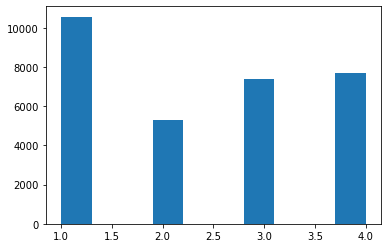

In [8]:
# plt.plot(deg_TCdir2SD)
# plt.plot(quad2TC,'.')
plt.hist(quad2TC)

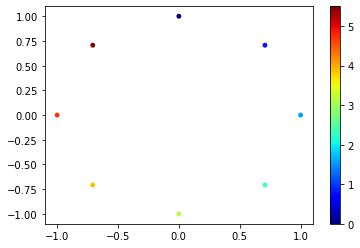

In [9]:
test_dir = np.arange(0,2*np.pi,0.25*np.pi)
plt.scatter(np.sin(test_dir),np.cos(test_dir),s=15,c=test_dir,cmap='jet')
plt.colorbar()

In [10]:
''' append degree from storm direction to SD location (positive clockwise) to data_out '''
data_out = np.column_stack( (data_out, quad2TC) )

''' write data_out to file '''
vars_str_out = ['SDnum','timestamp_SD','lonSD','latSD','UWND_MEAN(3.5m)','VWND_MEAN(3.5m)','dist2bt',\
                'TCname','timestamp_TC','usa_lonTC','usa_latTC','usa_sshs','usa_pres','usa_wind',\
                'usa_r34(Q1)','usa_r34(Q2)','usa_r34(Q3)','usa_r34(Q4)',\
                'usa_r64(Q1)','usa_r64(Q2)','usa_r64(Q3)','usa_r64(Q4)',\
                    'storm_speed','storm_dir','SDquadrant_2storm_dir']
units_str_out = ['(SD number)','(seconds since epoch)','(degE)','(degN)','(m/s)','(m/s)','(dist. to best track in km)',\
                 '(name)','(seconds since epoch)','(degE)','(degN)','()','(mb)','(kts)',\
                '(nmiles)','(nmiles)','(nmiles)','(nmiles)',\
                '(nmiles)','(nmiles)','(nmiles)','(nmiles)',\
                    '(kts)','(degrees)','(1~4 or cw in degreees)']
print('numbers of variable names & units to ouput:',len(vars_str_out),len(units_str_out))
print('shape of data_out:',data_out.shape)

''' write to file '''
fn_out = 'SD_intercept_TCs_tracks_NA_'+year+'.txt'
header_out = ', '.join(vars_str_out)+'\n'+', '.join(units_str_out)
np.savetxt(fn_out, data_out, fmt='%s', delimiter=' ',header=header_out)

numbers of variable names & units to ouput: 25 25
shape of data_out: (30933, 25)
